In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json
import pandas as pd
import seaborn as sn

In [2]:
def myrate(t, r):
    if t>=17:
        return r
    else:
        return 1

In [3]:
def mymodel(t, z, beta, mu, gamma, fD, delta_c, k, nu, r):
    S, E, I, R, H, D = z
    dD = gamma_H*H
    dH = fD*gamma*I - gamma_H*H - nu*H
    dR = (1-fD)*gamma*I + nu*H #nu non c'era nel weitz, da H a R
    dI = mu*E - gamma*I
    dS = -beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k) - mu*E 
    return [dS, dE, dI, dR, dH, dD]

In [4]:
def two_rate(t, r1, r2):
    if t>=17 and t<28:
        return r1
    elif t>=28 and t<85:
        return r2
    else:
        return 1

def twostep_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r1, r2):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dH = fD*gamma*I - gamma_H*H 
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H
    dI = mu*E - gamma*I
    dS = -beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k)
    dE = beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k) - mu*E 
    return [dS, dE, dI, dR, dH, dD]

In [5]:
R0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.31
r1 = 0.36
r2 = 0.26
delta_c = (50/60)*1e-6
N = 60*1e6


E0 = 1695
I0 = 308.8
H0 = 127.4
R0 = 311.1
S0 = 60.352*1e6
D0 = 0
N0 = E0+I0+H0+R0+S0
z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

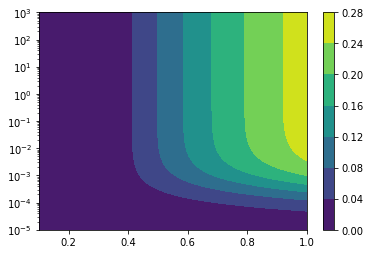

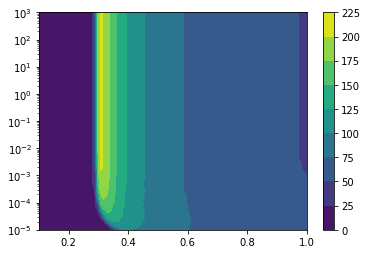

In [136]:
delta_c = np.logspace(-5, 3, 101)
rates = np.linspace(0.1, 1, 101)
t_max = 250
t = np.arange(t_max)
peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel, [0, t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value

X, Y = np.meshgrid(rates, delta_c)    
plt.contourf(X, Y, peak_values)
plt.yscale('log')
plt.colorbar()
plt.show()

plt.contourf(X, Y, peak_times)
plt.yscale('log')
plt.colorbar()
plt.show()

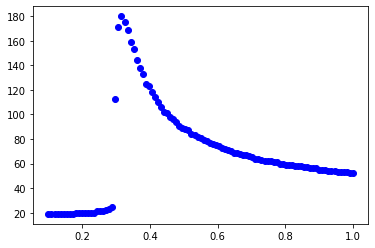

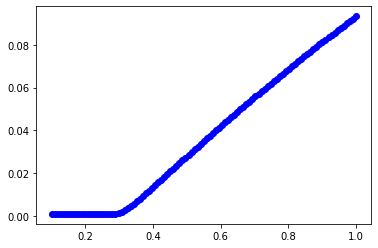

In [137]:
plt.plot(rates, peak_times[15,:], 'bo')
plt.show()
plt.plot(rates, peak_values[15,:], 'bo')
plt.show()

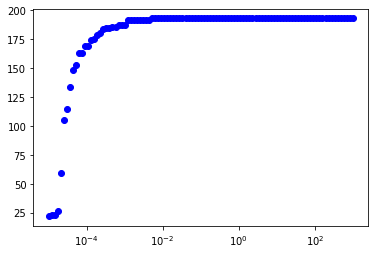

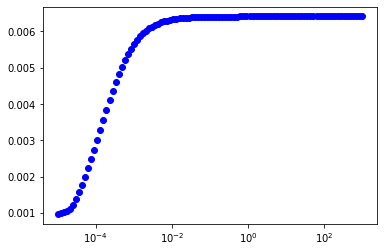

In [139]:
plt.plot(delta_c, peak_times[:,25], 'bo')
plt.xscale('log')
plt.show()
plt.plot(delta_c, peak_values[:,25], 'bo')
plt.xscale('log')
plt.show()

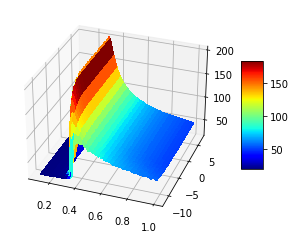

In [140]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, np.log(Y), peak_times, cmap='jet',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 290)
plt.show()

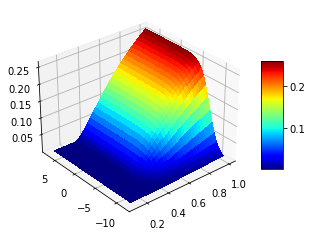

In [141]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, np.log(Y), peak_values, cmap='jet',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 230)
plt.show()

In [56]:
sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1e-2, k, nu, 0.33))
t = np.arange(t_max)
S, E, I, R, H, D = sol.sol(t)
peak_time = np.argmax(I)
peak_time

204

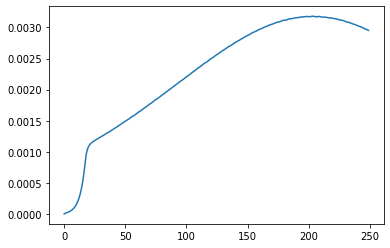

In [58]:
plt.plot(t,I)
plt.show()

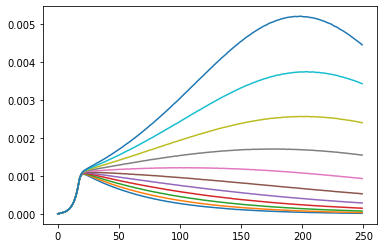

In [64]:
#Transition in rates
delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)
Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.show()

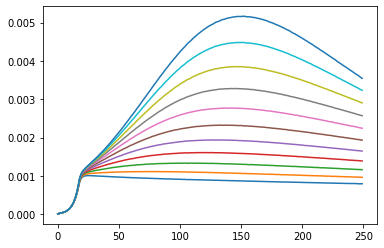

In [77]:
delta_c = np.logspace(-5, -4, 11)
rates = 0.35
Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, rates))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.show()

In [7]:
sol = solve_ivp(mymodel, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
sol2 = solve_ivp(twostep_model, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r1, r2))

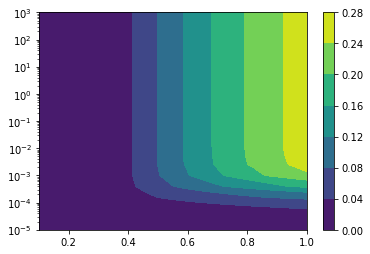

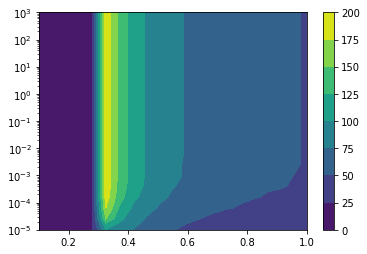

In [142]:
delta_c = np.logspace(-5, 3, 21)
rates = np.linspace(0.1, 1, 21)
t_max = 250
t = np.arange(t_max)
peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel, [0, t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, 2, nu, r))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value

X, Y = np.meshgrid(rates, delta_c)    
plt.contourf(X, Y, peak_values)
plt.yscale('log')
plt.colorbar()
plt.show()

plt.contourf(X, Y, peak_times)
plt.yscale('log')
plt.colorbar()
plt.show()

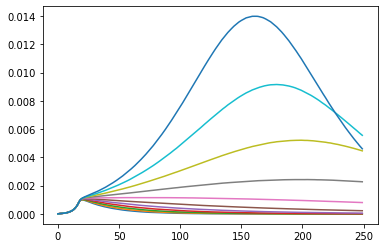

In [155]:
#Transition in rates
delta_c = 1e-1
rates = np.linspace(0.2, 0.35, 11)
Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, 4, nu, r))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.show()

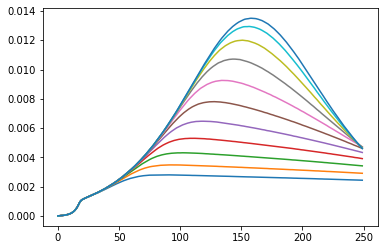

In [160]:
delta_c = np.logspace(-5, -4, 11)
rates = 0.35
Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, 4, nu, rates))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.show()

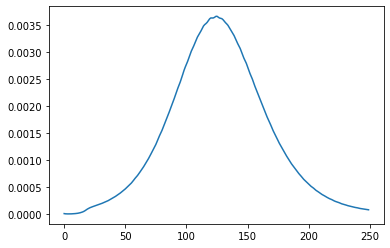

In [175]:
delta_c = 1e-2
sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, 1, nu, 0.4))
S, E, I, R, H, D = sol.sol(t)
d = gamma_H*nu*H
plt.plot(t, d/delta_c)

In [11]:
t = np.arange(85)
S, E, I, R, H, D = sol.sol(t)

In [12]:
S2, E2, I2, R2, H2, D2 = sol2.sol(t)

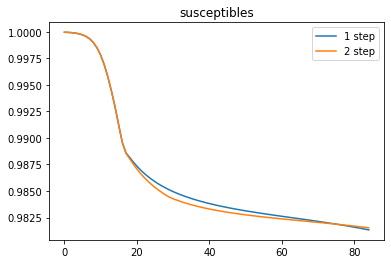

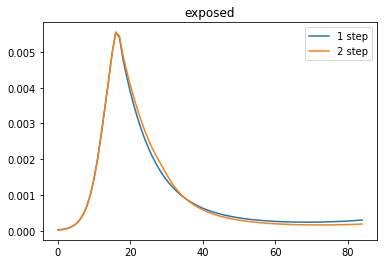

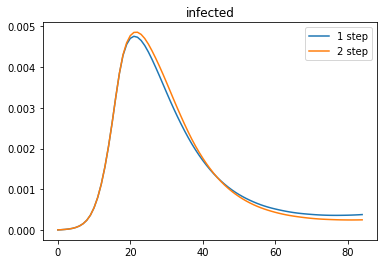

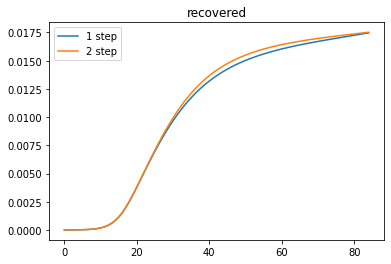

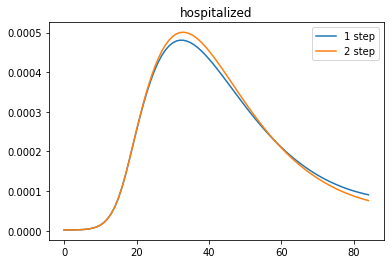

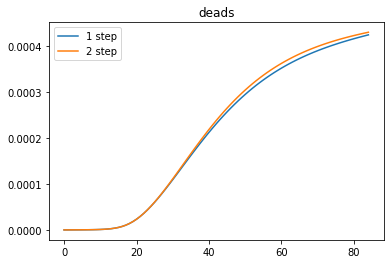

In [13]:
names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col2) in enumerate(zip(x, x2)):
    plt.figure(i)
    plt.plot(t, col.T, label = '1 step')
    plt.plot(t, col2.T, label = '2 step')
    plt.legend()
    plt.title(names[i])

In [15]:
f = open('Data/covid_data_dpc.json')
raw_data = json.load(f)

In [16]:
#from dictionary to dataframe
df = pd.DataFrame.from_dict(raw_data)
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN


In [17]:
# columns names
df.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')

In [18]:
# dataframe with reduced dates
# from 24/02 to 18/05 
df_red = df.loc[0:84]

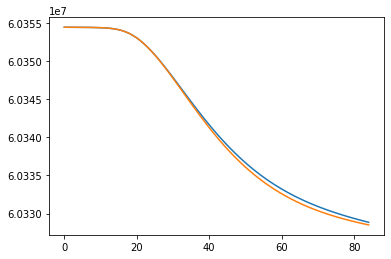

In [19]:
N = N0*(S+E+I+R+H)
N2 = N0*(S2+E2+I2+R2+H2)
plt.plot(t,N)
plt.plot(t,N2)

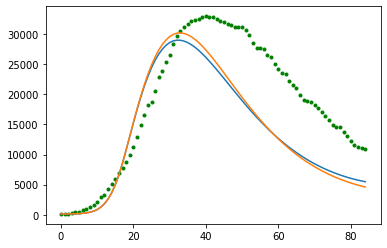

In [20]:
plt.plot(t, df_red['totale_ospedalizzati'], 'g.', label = 'data')
plt.plot(t, H*N)
plt.plot(t, H2*N2)
plt.show()